# Entrenamiento modelos de forma diaria:

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import PCA
import re
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
color_palette = sns.color_palette()

Cargamos los datos de la encuesta CADEM diaria y los features del dataset.

In [6]:
df = pd.read_csv("../data_reserva/features_dataset.csv")
df_encuestas = pd.read_csv("../data_reserva/encuesta.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/encuesta.csv'

In [1]:
df.head()

NameError: name 'df' is not defined

Configuramos como datetime las variables de fechas y creamos la variable week_start que define el inicio de la semana el dia domingo.

In [20]:
df["date"] = pd.to_datetime(df["date"])
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"])
df["week_start"] = df["date"] - pd.to_timedelta((df["date"].dt.weekday + 1) % 7, unit="D")
df_encuestas["week_start"] = df_encuestas["date"] - pd.to_timedelta((df_encuestas["date"].dt.weekday + 1) % 7, unit="D")
df_final = df.merge(df_encuestas[["week_start", "aprobacion_boric"]], on="week_start", how="left")
df_final = df_final.sort_values("date").dropna()

In [21]:
df_final["approval_rolling_7d"] = df_final["aprobacion_boric"].rolling(window=7, min_periods=7).mean()
df_final["approval_lag_7d"] = df_final["aprobacion_boric"].shift(1)
df_final["approval_diff"] = df_final["aprobacion_boric"].diff()
df_final["approval_pct_change"] = df_final["aprobacion_boric"].pct_change()
for lag in range(1, 8):  # Lags de 1 a 7 días
    df_final[f"score_positive_lag_{lag}"] = df_final["score_positive"].shift(lag)
    df_final[f"score_negative_lag_{lag}"] = df_final["score_negative"].shift(lag)
    df_final[f"score_neutral_lag_{lag}"] = df_final["score_neutral"].shift(lag)
df_final['score_negative_rolling7'] = df_final['score_negative'].rolling(window=7, min_periods=3).mean()
df_final['score_negative_rolling3'] = df_final['score_negative'].rolling(window=3, min_periods=3).mean()
df_final['sentiment_net'] = df_final['score_positive'] - df_final['score_negative']
df_final['sentiment_net_rolling7'] = df_final['sentiment_net'].rolling(window=7, min_periods=3).mean()
df_final = df_final.dropna()

In [22]:
cols_to_scale = ['retweetCount', 'replyCount', 'likeCount', 'quoteCount']
scaler = MinMaxScaler()
df_final[cols_to_scale] = scaler.fit_transform(df_final[cols_to_scale])
df_final = df_final.dropna()

In [23]:
target = 'aprobacion_boric'
X = df_final.drop(columns=['week_start', 'aprobacion_boric'], errors='ignore')
X = X.select_dtypes(exclude=['datetime'])

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_final[[target]])

In [24]:
df_final.head(10)

,date,score_positive,score_negative,score_neutral,retweetCount,replyCount,likeCount,quoteCount,robertuito_0,robertuito_1,...,score_positive_lag_6,score_negative_lag_6,score_neutral_lag_6,score_positive_lag_7,score_negative_lag_7,score_neutral_lag_7,score_negative_rolling7,score_negative_rolling3,sentiment_net,sentiment_net_rolling7
10,2022-03-20,0.025140,0.653711,0.321149,0.086775,0.018609,0.024285,0.045833,0.642830,0.913833,...,0.044447,0.556187,0.399367,0.068027,0.426942,0.505030,0.528101,0.584041,-0.628571,-0.419191
11,2022-03-21,0.358458,0.196829,0.444713,0.028667,0.180507,0.024696,0.262500,0.135075,0.444441,...,0.025492,0.825355,0.149153,0.044447,0.556187,0.399367,0.476765,0.572186,0.161628,-0.322995
12,2022-03-22,0.184142,0.432754,0.383104,0.043291,0.076297,0.053377,0.055903,0.386215,0.442125,...,0.114029,0.470782,0.415189,0.025492,0.825355,0.149153,0.420679,0.427765,-0.248612,-0.244245
13,2022-03-23,0.156160,0.432733,0.411107,0.015377,0.049017,0.032907,0.028037,0.186812,0.645427,...,0.243527,0.092264,0.664210,0.114029,0.470782,0.415189,0.415243,0.354105,-0.276573,-0.232791
14,2022-03-24,0.156160,0.432733,0.411107,0.015377,0.049017,0.032907,0.028037,0.186812,0.645427,...,0.297204,0.232395,0.470401,0.243527,0.092264,0.664210,0.463882,0.432740,-0.276573,-0.293911
15,2022-03-25,0.178047,0.500652,0.321301,0.037189,0.175855,0.027080,0.128125,0.157430,0.549981,...,0.012535,0.866016,0.121449,0.297204,0.232395,0.470401,0.502204,0.455373,-0.322605,-0.349255
16,2022-03-26,0.334819,0.084209,0.580971,0.049780,0.017679,0.032083,0.050000,0.457494,0.483654,...,0.025140,0.653711,0.321149,0.012535,0.866016,0.121449,0.390517,0.339198,0.250610,-0.191528
17,2022-03-27,0.178145,0.486582,0.335273,0.038223,0.037683,0.033265,0.045486,0.060685,0.422024,...,0.358458,0.196829,0.444713,0.025140,0.653711,0.321149,0.366642,0.357148,-0.308438,-0.145795
18,2022-03-28,0.142828,0.477701,0.379471,0.071667,0.060200,0.038415,0.078333,0.288680,0.273621,...,0.184142,0.432754,0.383104,0.358458,0.196829,0.444713,0.406766,0.349498,-0.334873,-0.216723
19,2022-03-29,0.128853,0.577602,0.293545,0.078679,0.023540,0.033529,0.045000,0.278210,0.545129,...,0.156160,0.432733,0.411107,0.184142,0.432754,0.383104,0.427459,0.513962,-0.448749,-0.245314


Ahora creamos la base más básica, sólamente con los scores, para correr una regresión lineal simple.

In [26]:
 # Se excluye 'date' porque no es numérica
y = df_final['aprobacion_boric']  # Variable objetivo

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Guardar las fechas desde el DataFrame original
fechas = df_final['date'].reset_index(drop=True)
fechas_train, fechas_test = train_test_split(fechas, test_size=0.2, random_state=42)

## Random Forest:

Comenzamos con un modelo de Random Forest.

In [27]:
modelo_rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=4, max_features='sqrt', random_state=42, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌲 Random Forest - MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


🌲 Random Forest - MAE: 0.08, R²: 0.59


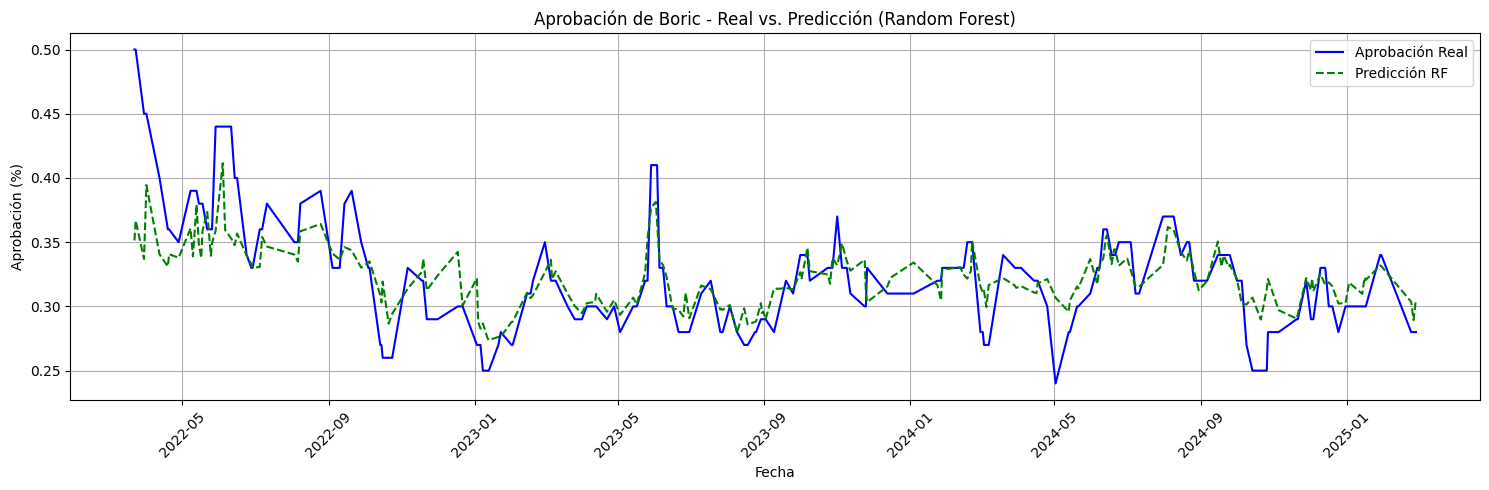

In [28]:
y_test_real = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(np.array(y_pred_rf).reshape(-1, 1)).flatten()

df_results = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real,
    'Predicción Random Forest': y_pred_real
}).sort_values(by='Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_results['Fecha'], df_results['Aprobación Real'], linestyle='-', color='blue', label='Aprobación Real')
plt.plot(df_results['Fecha'], df_results['Predicción Random Forest'], linestyle='--', color='green', label='Predicción RF')

plt.title('Aprobación de Boric - Real vs. Predicción (Random Forest)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Veamos la calidad de la predicción analizando la calidad o importancia de las variables predictoras:

In [29]:
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# === 2. Mostrar las top 15 variables ===
print("🎯 Variables más importantes (top 15):")
print(importancias.head(15))

🎯 Variables más importantes (top 15):
                           Variable  Importancia
787             approval_rolling_7d     0.149415
788                 approval_lag_7d     0.116100
812         score_negative_rolling7     0.019383
815          sentiment_net_rolling7     0.016508
776  weighted_negative_retweetCount     0.006535
625                  robertuito_618     0.005803
221                  robertuito_214     0.005691
801            score_negative_lag_4     0.005079
580                  robertuito_573     0.005029
813         score_negative_rolling3     0.004697
804            score_negative_lag_5     0.004644
713                  robertuito_706     0.003968
653                  robertuito_646     0.003936
386                  robertuito_379     0.003857
117                  robertuito_110     0.003690


In [30]:
top_vars = importancias.head(15)['Variable'].tolist()

target = 'aprobacion_boric'
df_model = df_final.copy()
df_model = df_model.dropna(subset=top_vars + [target])  # Eliminar filas con NaN en las variables clave

X_top = df_model[top_vars]
y = df_model[target]
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_top)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

# Desescalar
y_test_real_rf = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_rf = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Métricas
mae = mean_absolute_error(y_test_real_rf, y_pred_real_rf)
r2 = r2_score(y_test_real_rf, y_pred_real_rf)

print(f"🌲 Random Forest con X_top - MAE: {mae:.4f}, R²: {r2:.4f}")

🌲 Random Forest con X_top - MAE: 0.0087, R²: 0.9018


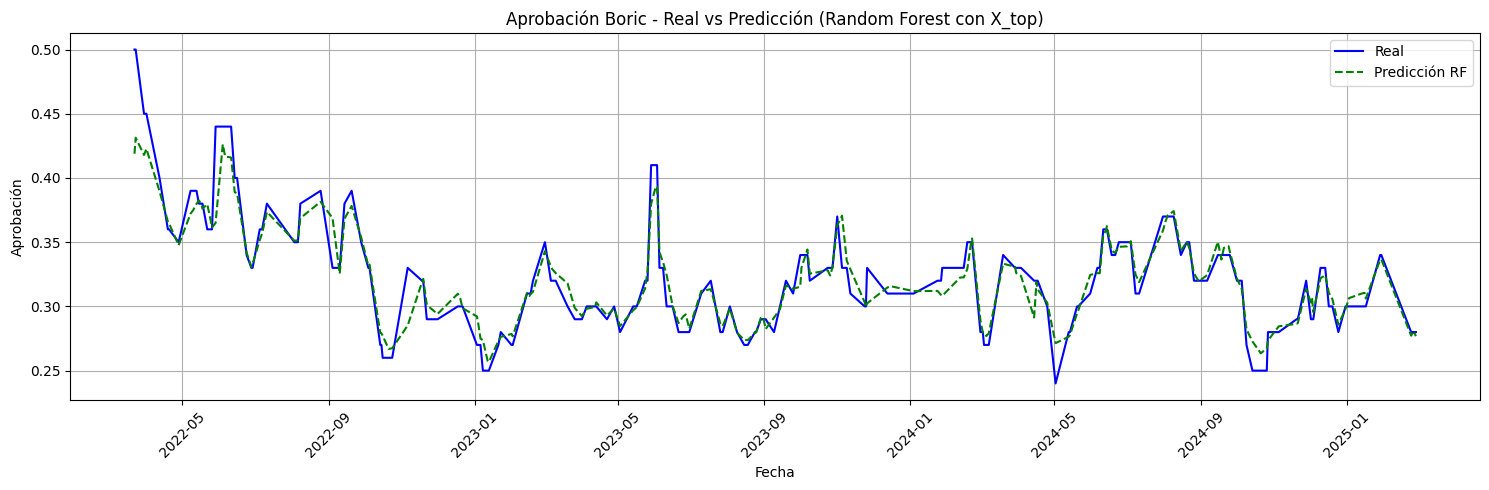

In [33]:
# Crear DataFrame con resultados
df_resultado = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_rf,
    'Predicción RF': y_pred_real_rf
}).sort_values('Fecha')  # ordenar cronológicamente

plt.figure(figsize=(15, 5))
plt.plot(df_resultado['Fecha'], df_resultado['Aprobación Real'], label='Real', color='blue')
plt.plot(df_resultado['Fecha'], df_resultado['Predicción RF'], label='Predicción RF', color='green', linestyle='--')
plt.title('Aprobación Boric - Real vs Predicción (Random Forest con X_top)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

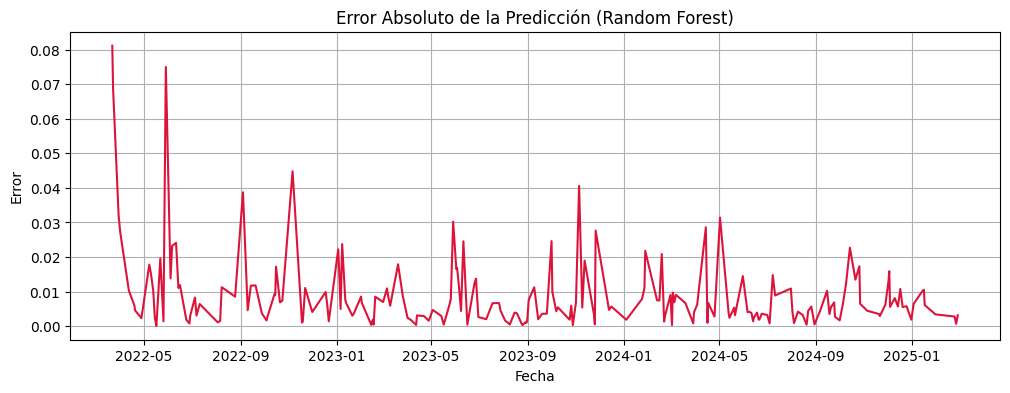

In [34]:
df_resultado['Error Absoluto'] = np.abs(df_resultado['Aprobación Real'] - df_resultado['Predicción RF'])
plt.figure(figsize=(12, 4))
plt.plot(df_resultado['Fecha'], df_resultado['Error Absoluto'], label='Error Absoluto', color='crimson')
plt.title('Error Absoluto de la Predicción (Random Forest)')
plt.xlabel('Fecha')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [35]:
# Agregar columna de error absoluto
df_resultado['Error Absoluto'] = np.abs(df_resultado['Aprobación Real'] - df_resultado['Predicción RF'])
top_errores = df_resultado.sort_values(by='Error Absoluto', ascending=False).head(10)
print(top_errores[['Fecha', 'Aprobación Real', 'Predicción RF', 'Error Absoluto']])

         Fecha  Aprobación Real  Predicción RF  Error Absoluto
203 2022-03-22             0.50       0.418875        0.081125
21  2022-05-29             0.44       0.365022        0.074978
155 2022-03-23             0.50       0.431323        0.068677
200 2022-11-06             0.33       0.285186        0.044814
72  2023-11-05             0.33       0.370600        0.040600
168 2022-09-04             0.33       0.368732        0.038732
114 2022-03-30             0.45       0.417923        0.032077
147 2024-05-02             0.24       0.271411        0.031411
165 2023-05-29             0.41       0.379772        0.030228
134 2024-04-14             0.32       0.291394        0.028606


## XGBoost:

In [49]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="mae",
    early_stopping_rounds=20,
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"⚡ XGBoost - MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")

import joblib

joblib.dump(xgb_model, "../models/modelo_xgb.pkl")
joblib.dump(scaler_X, "../models/scaler_X.pkl")
joblib.dump(scaler_y, "../models/scaler_y.pkl")
joblib.dump(top_vars, "../models/feature_names.pkl")


/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


⚡ XGBoost - MAE: 0.02, R²: 0.94


['../models/feature_names.pkl']

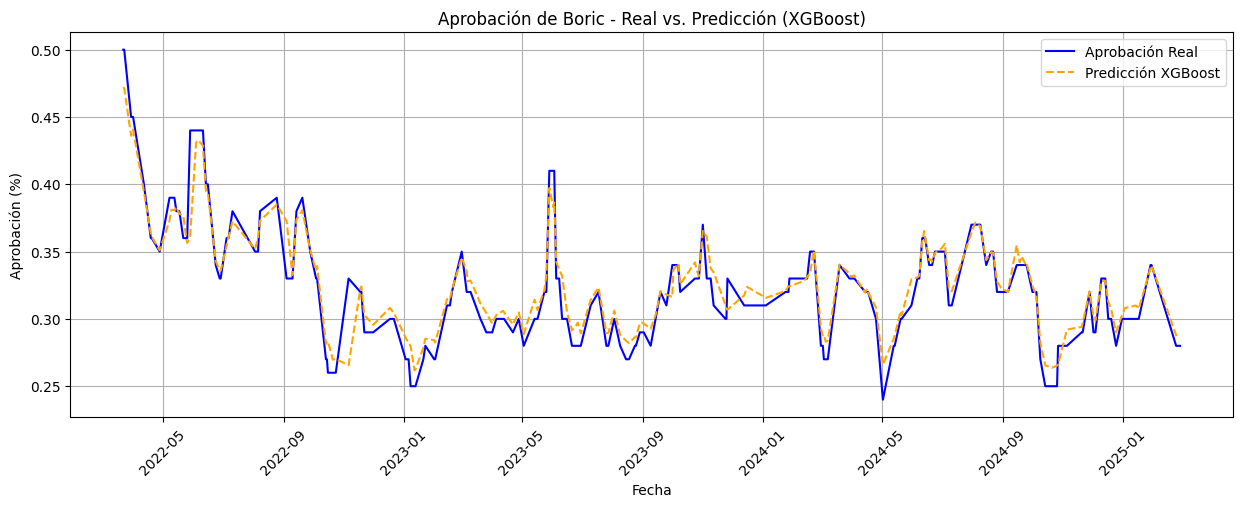

In [48]:
y_test_real_xgb = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_xgb = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

df_results = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_xgb,
    'Predicción XGBoost': y_pred_real_xgb
})


df_results = df_results.sort_values(by='Fecha')
plt.figure(figsize=(15, 5))
plt.plot(df_results['Fecha'], df_results['Aprobación Real'], linestyle='-', color='blue', label='Aprobación Real')
plt.plot(df_results['Fecha'], df_results['Predicción XGBoost'], linestyle='--', color='orange', label='Predicción XGBoost')
plt.title('Aprobación de Boric - Real vs. Predicción (XGBoost)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

dict_keys(['validation_0', 'validation_1'])
odict_keys(['mae'])
odict_keys(['mae'])


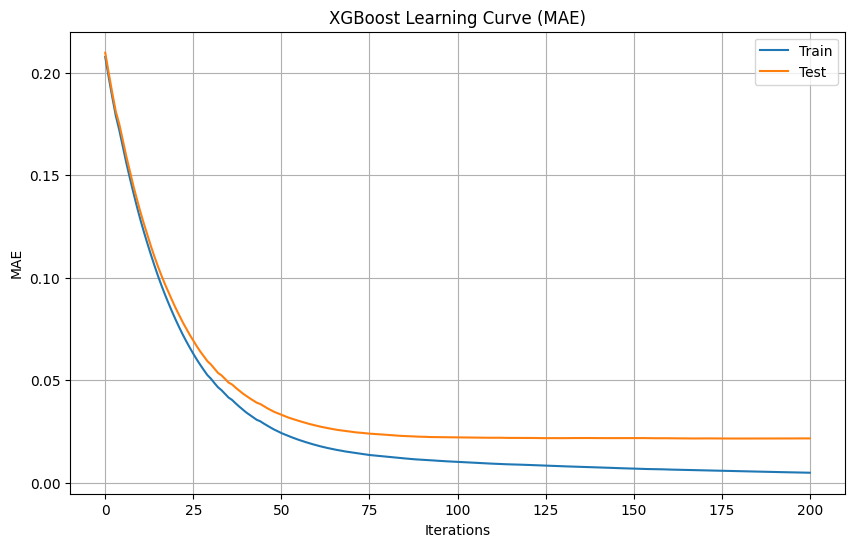

In [45]:
eval_set=[(X_train, y_train), (X_test, y_test)]
results = xgb_model.evals_result()
print(results.keys())  # Debería incluir ambos sets
print(results["validation_0"].keys())  # Debería incluir "mae"
print(results["validation_1"].keys())  # También debería incluir "mae"
epochs = len(results["validation_0"]["mae"])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results["validation_0"]["mae"], label="Train")
plt.plot(x_axis, results["validation_1"]["mae"], label="Test")
plt.xlabel("Iterations")
plt.ylabel("MAE")
plt.title("XGBoost Learning Curve (MAE)")
plt.legend()
plt.grid(True)
plt.show()

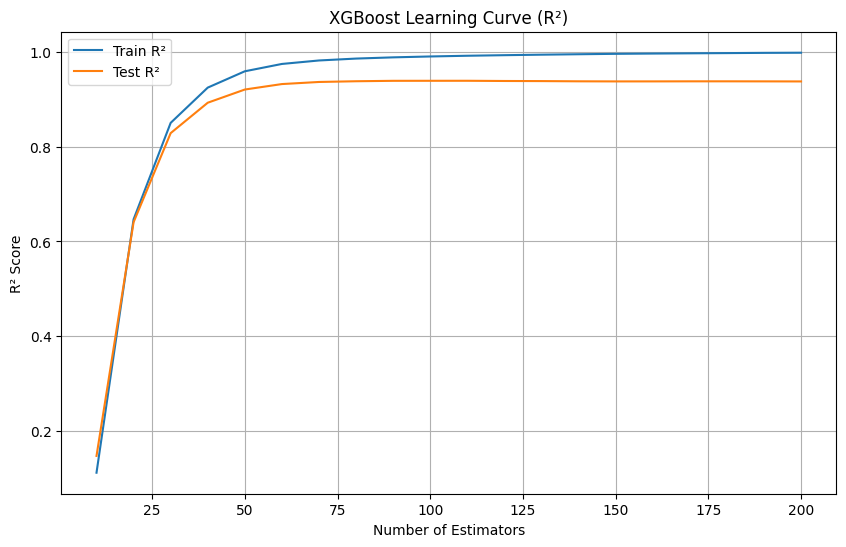

In [46]:
from sklearn.metrics import r2_score

r2_train = []
r2_test = []

# Entrenar en pasos de 10 iteraciones
for i in range(10, 201, 10):  # Ajusta el rango si necesitas más iteraciones
    model = xgb.XGBRegressor(
        objective="reg:squarederror", 
        n_estimators=i,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8, 
        colsample_bytree=0.8, 
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Predicciones y R²
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train.append(r2_score(y_train, y_train_pred))
    r2_test.append(r2_score(y_test, y_test_pred))

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(range(10, 201, 10), r2_train, label="Train R²")
plt.plot(range(10, 201, 10), r2_test, label="Test R²")
plt.xlabel("Number of Estimators")
plt.ylabel("R² Score")
plt.title("XGBoost Learning Curve (R²)")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
from sklearn.model_selection import cross_val_score

xgb_model_cv = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100,  # según tu gráfico, esto es suficiente
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8, 
    colsample_bytree=0.8,
    random_state=42
)

# Validación cruzada con 5 folds
scores = cross_val_score(xgb_model_cv, X_train, y_train, 
                         scoring='r2', cv=5)

# Resultados
print("🔍 Validación cruzada (R²):")
print(f"Scores por fold: {scores}")
print(f"Media: {scores.mean():.3f}")
print(f"Desviación estándar: {scores.std():.3f}")

🔍 Validación cruzada (R²):
Scores por fold: [0.95385181 0.92943561 0.90510787 0.91969244 0.94657292]
Media: 0.931
Desviación estándar: 0.018


## KNN:

In [89]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
knn_model.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_knn = knn_model.predict(X_test_scaled)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"📊 KNN - MAE: {mae_knn:.4f}, R²: {r2_knn:.4f}")

📊 KNN - MAE: 0.0536, R²: 0.8116


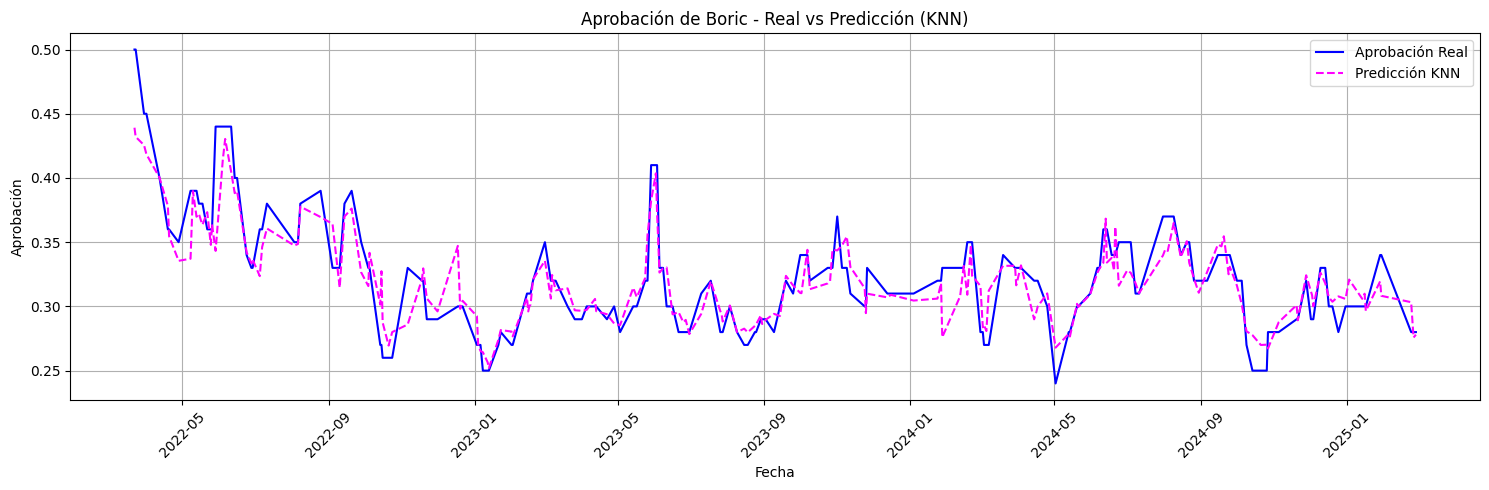

In [90]:
y_pred_real_knn = scaler_y.inverse_transform(y_pred_knn.reshape(-1, 1)).flatten()
y_test_real_knn = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

df_knn = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_knn,
    'Predicción KNN': y_pred_real_knn
}).sort_values('Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_knn['Fecha'], df_knn['Aprobación Real'], label='Aprobación Real', color='blue')
plt.plot(df_knn['Fecha'], df_knn['Predicción KNN'], label='Predicción KNN', color='magenta', linestyle='--')

plt.title('Aprobación de Boric - Real vs Predicción (KNN)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

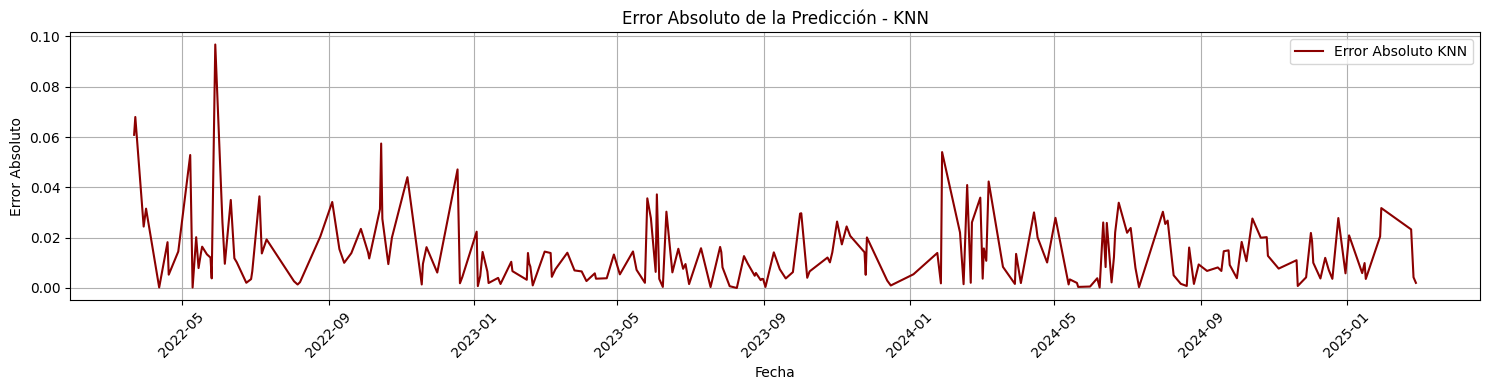

In [91]:
df_knn['Error Absoluto'] = np.abs(df_knn['Aprobación Real'] - df_knn['Predicción KNN'])
plt.figure(figsize=(15, 4))
plt.plot(df_knn['Fecha'], df_knn['Error Absoluto'], color='darkred', label='Error Absoluto KNN')
plt.title('Error Absoluto de la Predicción - KNN')
plt.xlabel('Fecha')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## MLP:

In [92]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # salida para regresión
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

y_pred = model.predict(X_test).flatten()
y_test_real_mlp = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real_mlp = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_real_mlp, y_pred_real_mlp)
r2 = r2_score(y_test_real_mlp, y_pred_real_mlp)

print(f"🤖 MLP - MAE: {mae:.4f}, R²: {r2:.4f}")

Epoch 1/100


/home/pollodk/.pyenv/versions/3.10.6/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0759 - val_loss: 0.0094
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0039
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0043
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0038
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_lo

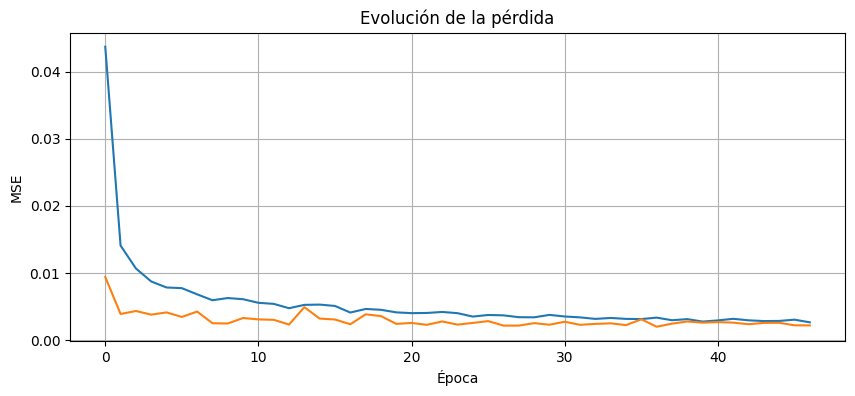

In [93]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Val)')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend
plt.grid(True)
plt.show()

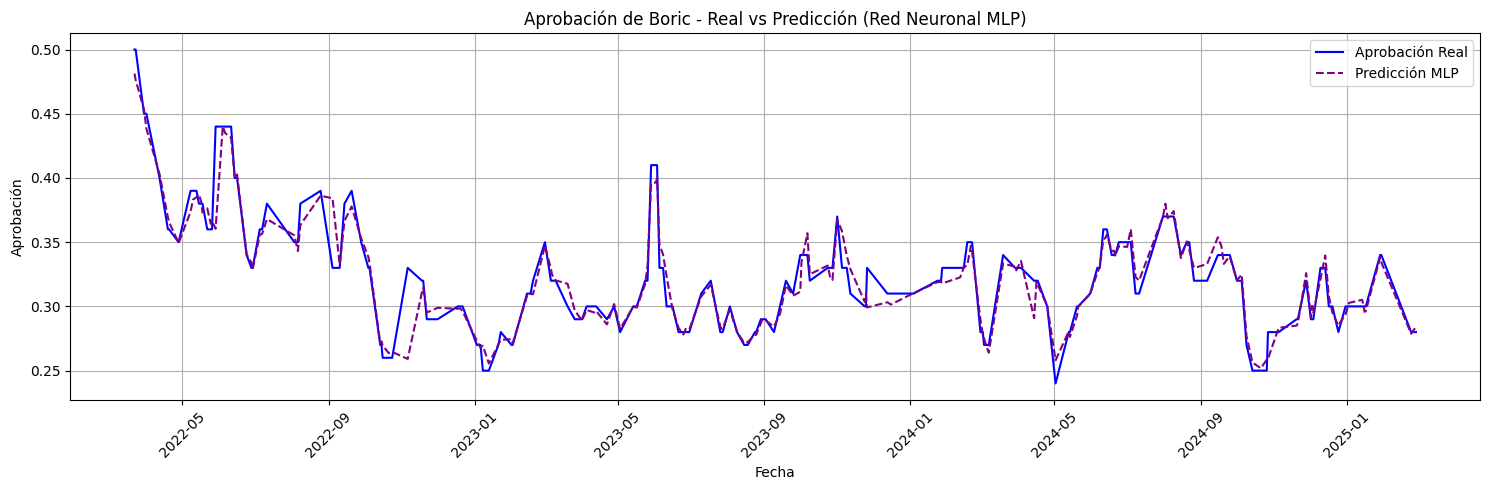

In [94]:
df_result_mlp = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real_mlp,
    'Predicción MLP': y_pred_real_mlp
}).sort_values('Fecha')

plt.figure(figsize=(15, 5))
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Aprobación Real'], label='Aprobación Real', color='blue')
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Predicción MLP'], label='Predicción MLP', color='purple', linestyle='--')
plt.title('Aprobación de Boric - Real vs Predicción (Red Neuronal MLP)')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

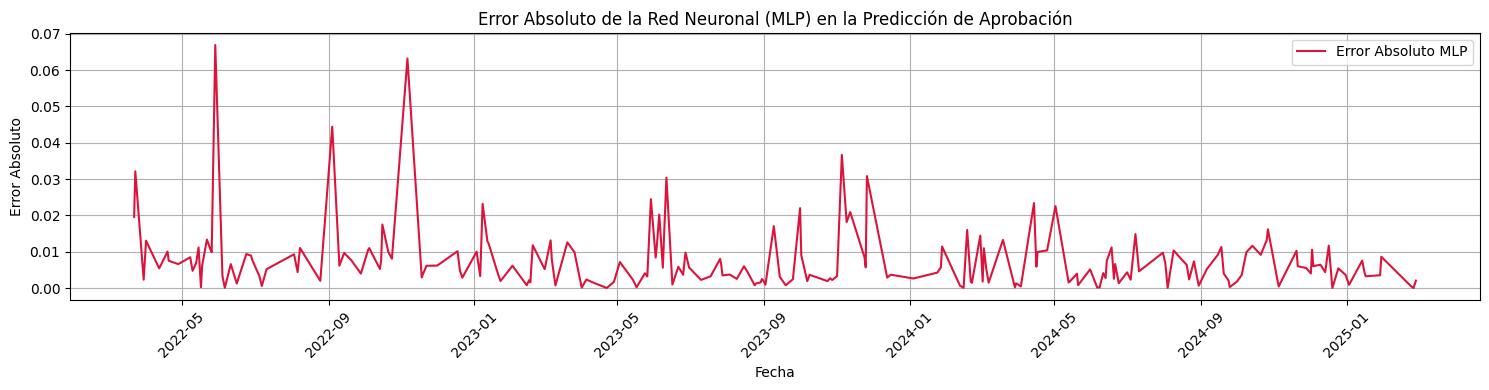

In [74]:
df_result_mlp['Error Absoluto'] = np.abs(df_result_mlp['Aprobación Real'] - df_result_mlp['Predicción MLP'])
plt.figure(figsize=(15, 4))
plt.plot(df_result_mlp['Fecha'], df_result_mlp['Error Absoluto'], color='crimson', label='Error Absoluto MLP')
plt.title('Error Absoluto de la Red Neuronal (MLP) en la Predicción de Aprobación')
plt.xlabel('Fecha')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Comparación de resultados:

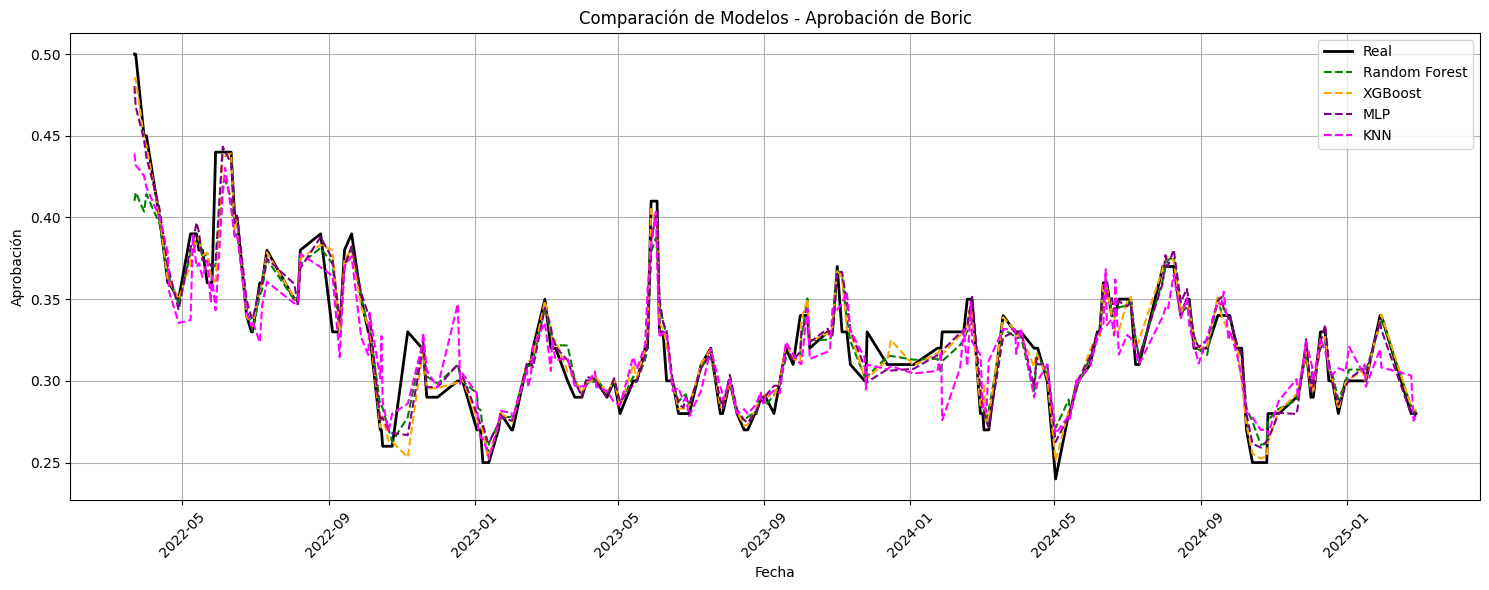

In [75]:
df_comparacion = pd.DataFrame({
    'Fecha': fechas_test.values,
    'Aprobación Real': y_test_real,
    'Random Forest': y_pred_real_rf,
    'XGBoost': y_pred_real_xgb,
    'MLP': y_pred_real_mlp,
    'KNN': y_pred_real_knn
}).sort_values(by='Fecha')

plt.figure(figsize=(15, 6))
plt.plot(df_comparacion['Fecha'], df_comparacion['Aprobación Real'], label='Real', color='black', linewidth=2)
plt.plot(df_comparacion['Fecha'], df_comparacion['Random Forest'], label='Random Forest', linestyle='--', color='green')
plt.plot(df_comparacion['Fecha'], df_comparacion['XGBoost'], label='XGBoost', linestyle='--', color='orange')
plt.plot(df_comparacion['Fecha'], df_comparacion['MLP'], label='MLP', linestyle='--', color='purple')
plt.plot(df_comparacion['Fecha'], df_comparacion['KNN'], label='KNN', linestyle='--', color='magenta')

plt.title('Comparación de Modelos - Aprobación de Boric')
plt.xlabel('Fecha')
plt.ylabel('Aprobación')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()